In [31]:
import numpy as np
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, inconsistent
from gensim.models import KeyedVectors
from openpyxl import load_workbook

## Extracting Data (from topics excel file)

In [32]:
data_path = "data"
topics_file = "lda_topics_by_division.xlsx"

topic_keyphrase_lists = {}
wb = load_workbook(f"{data_path}/{topics_file}", data_only=True)

for sheet_name in wb.sheetnames:
    ws = wb[sheet_name]
    #print("\nTopic:", sheet_name)

    keyphrases = []
    for row in ws.iter_rows(min_col=2, min_row=2, values_only=True):
        #print(list(row))
        keyphrases.append(list(row))
    
    topic_keyphrase_lists[sheet_name] = keyphrases

## Function Setup

In [33]:
def topic_centroid(keyphrases, model):
    keyphrases_clean = [k.replace("_", " ") for k in keyphrases]
    embs = model.encode(keyphrases_clean, normalize_embeddings=True)
    centroid = embs.mean(axis=0) # calculate "centroid" of embedding vals
    
    centroid = centroid / (np.linalg.norm(centroid) + 1e-9) # re-normalize centroid
    return centroid

In [34]:
def plot_similarity_matrix(topic_vectors, topic):
    topic_sim_matrix = topic_vectors @ topic_vectors.T

    topic_ids = [f"Topic {i + 1}" for i in range(len(topic_vectors))]

    # Convert to df for cleaner display
    sim_df = pd.DataFrame(topic_sim_matrix, index=topic_ids, columns=topic_ids)

    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_df, annot=True, fmt=".2f", cmap="viridis", vmin=-1, vmax=1)
    plt.title(f"Topic Similarity Matrix ({topic})")
    plt.show()

In [35]:
def plot_clustering_dendogram(topic_vectors, topic):
    dist_matrix = pdist(topic_vectors, metric="cosine")

    # hierarchical clustering
    Z = linkage(dist_matrix, method="ward")

    topic_ids = [f"Topic {i + 1}" for i in range(len(topic_vectors))]

    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=topic_ids, leaf_rotation=90)
    plt.axhline(y=0.15, c='red', linestyle='--')
    plt.title(f"Hierarchical Clustering Dendrogram ({topic})")
    plt.xlabel("Topic Index")
    plt.ylabel("Distance (1 - cosine similarity)")
    plt.show()

In [36]:
def plot_inconsistency_diagram(topic_vectors, topic):
    dist_matrix = pdist(topic_vectors, metric="cosine")

    # hierarchical clustering
    Z = linkage(dist_matrix, method="ward")

    merge_distances = Z[:, 2]      # distance at each merge
    inc = inconsistent(Z)
    coeff = inc[:, -1]

    plt.figure(figsize=(8, 5))
    plt.scatter(merge_distances, coeff)
    plt.xlabel("Merge distance")
    plt.ylabel("Inconsistency coefficient")
    plt.title(f"Inconsistency vs Merge Distance ({topic})")
    plt.tight_layout()
    plt.show()

## Loading Model

In [37]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

## Analysis

In [38]:
topic_embs = {}

for topic in topic_keyphrase_lists.keys():
    topic_vectors = []

    for keyphrase_list in topic_keyphrase_lists[topic]:
        emb = topic_centroid(keyphrase_list, model)
        topic_vectors.append(emb)
    
    topic_embs[topic] = topic_vectors

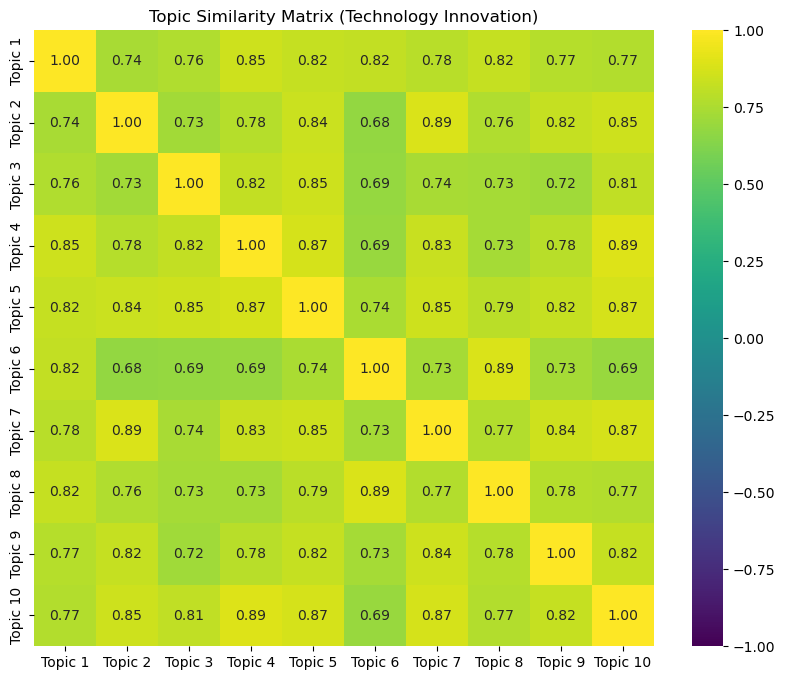

In [ ]:
for topic in topic_embs.keys():
    topic_vectors = np.vstack(topic_embs[topic])
    plot_similarity_matrix(topic_vectors, topic)

    break


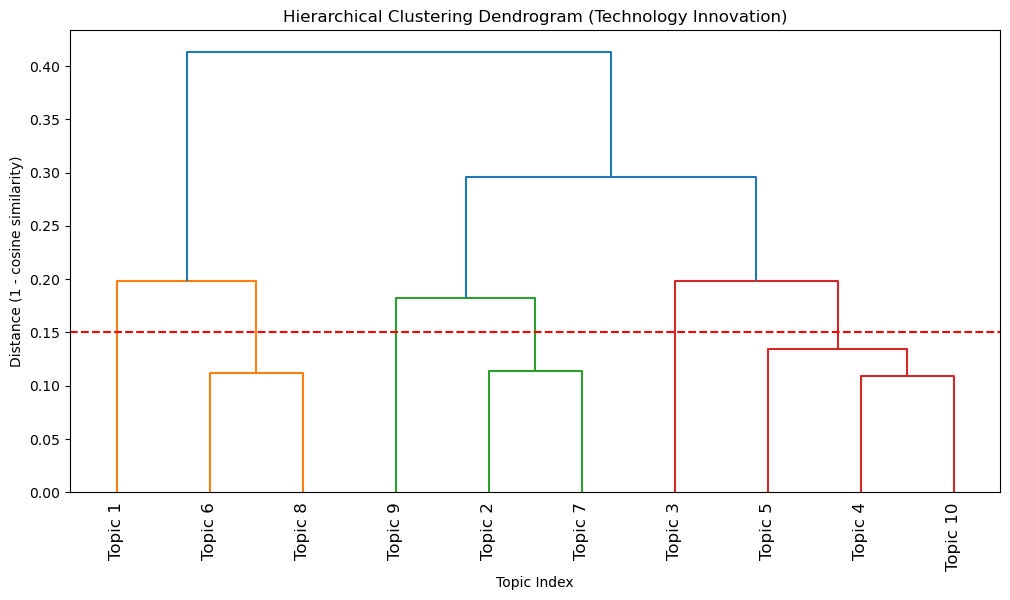

In [40]:
for topic in topic_embs.keys():
    topic_vectors = np.vstack(topic_embs[topic])
    plot_clustering_dendogram(topic_vectors, topic)

    break


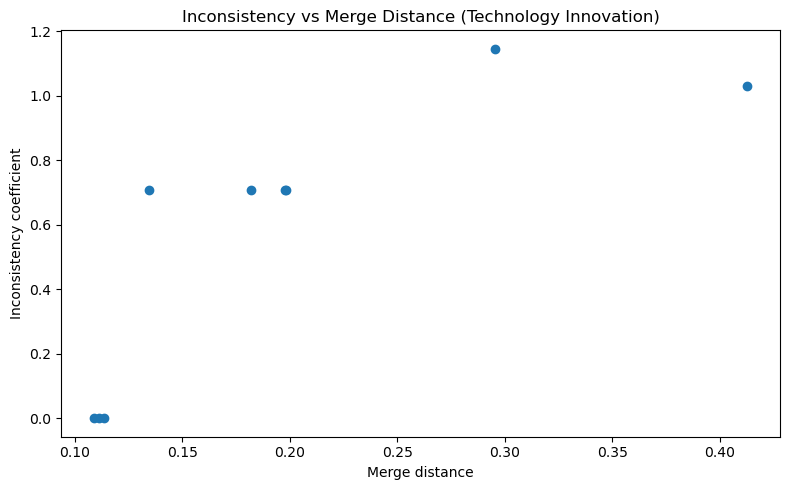

In [41]:
for topic in topic_embs.keys():
    topic_vectors = np.vstack(topic_embs[topic])
    plot_inconsistency_diagram(topic_vectors, topic)

    break

## Perform Cluster (at threshold=0.15)

In [42]:
def perform_subtopic_clustering(topic_vectors, topic, threshold):
    dist_matrix = pdist(topic_vectors, metric="cosine")

    topic_ids = [f"Topic {i + 1}" for i in range(len(topic_vectors))]
    Z = linkage(dist_matrix, method="ward")

    cluster_labels = fcluster(Z, t=threshold, criterion="distance")
    # cluster_labels is an array of ints, length = n_topics

    # group topics by cluster
    topic_cluster_dict = {}
    for tid, cid in zip(topic_ids, cluster_labels):
        topic_cluster_dict[tid] = cid

    return topic_cluster_dict

In [47]:
print(topic_keyphrase_lists)

{'Technology Innovation': [['food', 'product', 'plant', 'sample', 'water', 'test', 'health', 'crop', 'production', 'pathogen', 'chemical', 'reduce', 'produce', 'soil', 'treatment', 'novel', 'field', 'agricultural', 'rapid', 'effective'], ['datum', 'time', 'machine', 'software', 'real', 'improve', 'algorithm', 'solution', 'learning', 'enable', 'information', 'artificial_intelligence', 'analysis', 'tool', 'management', 'network', 'application', 'business_innovation_sbir_phase', 'automate', 'sensor'], ['energy', 'power', 'battery', 'storage', 'cell', 'solar', 'thermal', 'performance', 'heat', 'temperature', 'charge', 'grid', 'reduce', 'lithium', 'increase', 'renewable', 'market', 'improve', 'vehicle', 'fuel'], ['material', 'process', 'production', 'product', 'manufacturing', 'produce', 'industry', 'reduce', 'chemical', 'scale', 'property', 'waste', 'polymer', 'energy', 'application', 'performance', 'enable', 'metal', 'gas', 'surface'], ['water', 'reduce', 'design', 'energy', 'increase', '

In [45]:
cluster_assignments = {}
cluster_threshold = 0.15

for topic in topic_embs.keys():
    topic_vectors = np.vstack(topic_embs[topic])
    cluster_assignments[topic] = perform_subtopic_clustering(topic_vectors, topic, cluster_threshold)

print(cluster_assignments)

{'Technology Innovation': {'Topic 1': 2, 'Topic 2': 3, 'Topic 3': 6, 'Topic 4': 5, 'Topic 5': 5, 'Topic 6': 1, 'Topic 7': 3, 'Topic 8': 1, 'Topic 9': 4, 'Topic 10': 5}, 'Chemical, Bioengineering, Envir': {'Topic 1': 4, 'Topic 2': 3, 'Topic 3': 4, 'Topic 4': 2, 'Topic 5': 6, 'Topic 6': 2, 'Topic 7': 1, 'Topic 8': 5, 'Topic 9': 4, 'Topic 10': 1}, 'Biological Infrastructure': {'Topic 1': 2, 'Topic 2': 6, 'Topic 3': 5, 'Topic 4': 1, 'Topic 5': 3, 'Topic 6': 5, 'Topic 7': 1, 'Topic 8': 4, 'Topic 9': 6, 'Topic 10': 4}, 'Mathematical Sciences': {'Topic 1': 3, 'Topic 2': 1, 'Topic 3': 4, 'Topic 4': 3, 'Topic 5': 7, 'Topic 6': 2, 'Topic 7': 4, 'Topic 8': 1, 'Topic 9': 6, 'Topic 10': 5}, 'Civil, Mechanical and Manufactu': {'Topic 1': 3, 'Topic 2': 2, 'Topic 3': 1, 'Topic 4': 1, 'Topic 5': 2, 'Topic 6': 4, 'Topic 7': 3, 'Topic 8': 2, 'Topic 9': 3, 'Topic 10': 5}, 'Research on Innovative Technolo': {'Topic 1': 4, 'Topic 2': 4, 'Topic 3': 1, 'Topic 4': 3, 'Topic 5': 4, 'Topic 6': 4, 'Topic 7': 5, '

## Reproduce Topics by Division spreadsheet w/ new clusters

In [51]:
cluster_topic_keyphrase_lists = {}

for topic in topic_keyphrase_lists:
    keyphrases = {}

    for i, keyphrase_list in enumerate(topic_keyphrase_lists[topic]):
        old_subtopic = f"Topic {i + 1}"
        cluster = cluster_assignments[topic][old_subtopic]

        if cluster in keyphrases:
            keyphrases[cluster].update(keyphrase_list)
        else:
            keyphrases[cluster] = set(keyphrase_list)

    cluster_topic_keyphrase_lists[topic] = keyphrases


In [50]:
def dict_to_multisheet_excel(data, excel_path="clustered_subtopics_by_division.xlsx"):
    with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
        
        for division, clusters in data.items():
            
            # Build rows for this division
            rows = []
            for cluster_id, words in clusters.items():
                row = {
                    "Cluster": cluster_id,
                }
                # Put words across columns word_1, word_2, ...
                for i, w in enumerate(words, start=1):
                    row[f"word_{i}"] = w
                rows.append(row)

            # Convert to DataFrame
            df = pd.DataFrame(rows)
            
            # Excel sheet names cannot contain characters like "/"
            safe_sheet_name = division.replace("/", "_").replace("\\", "_")
            
            # Write this division's data into its own sheet
            df.to_excel(writer, sheet_name=safe_sheet_name[:31], index=False)

    print(f"Saved Excel file to: {excel_path}")

In [53]:
dict_to_multisheet_excel(cluster_topic_keyphrase_lists)

Saved Excel file to: clustered_subtopics_by_division.xlsx


## Reclassify Grants w/ new clusters

In [80]:
orig_assignments = pd.read_csv("data/topic_assignments.csv")
orig_assignments.drop(orig_assignments.columns[0], axis=1, inplace=True)

/var/folders/41/bwp8gqhn2yl8qs11cmbb8y280000gn/T/ipykernel_23673/1125137051.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  orig_assignments = pd.read_csv("data/topic_assignments.csv")


In [98]:
def plot_yearly_cluster_dist(df, cluster_cols, topic):
    plt.figure(figsize=(10,6))

    for col in cluster_cols:
        plt.plot(df["year"], df[col], marker="o", label=col)

    plt.xlabel("Year")
    plt.ylabel("Percentage")
    plt.title(f"Mean Cluster Topic Percentages by Year ({topic})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

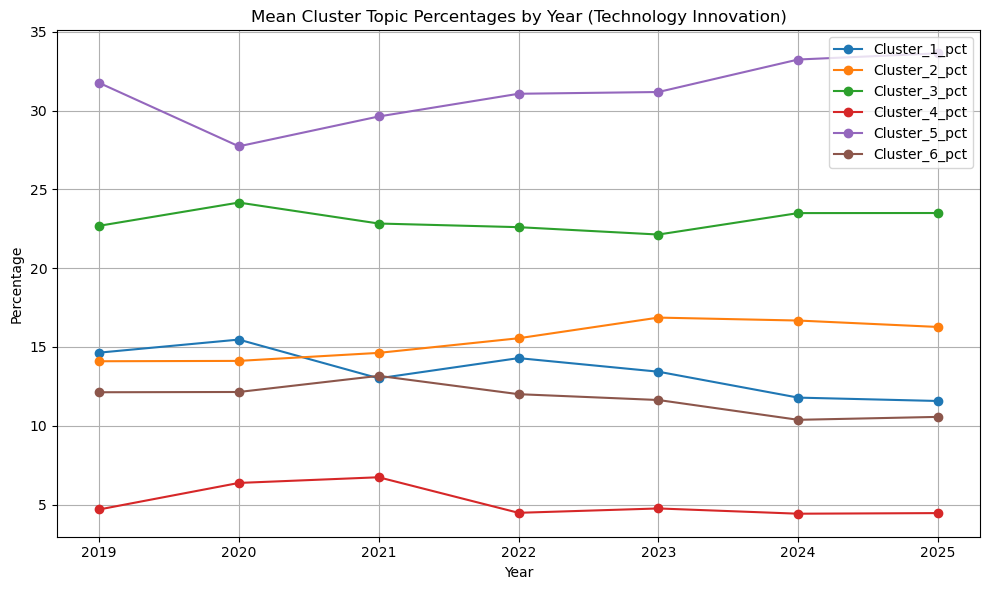

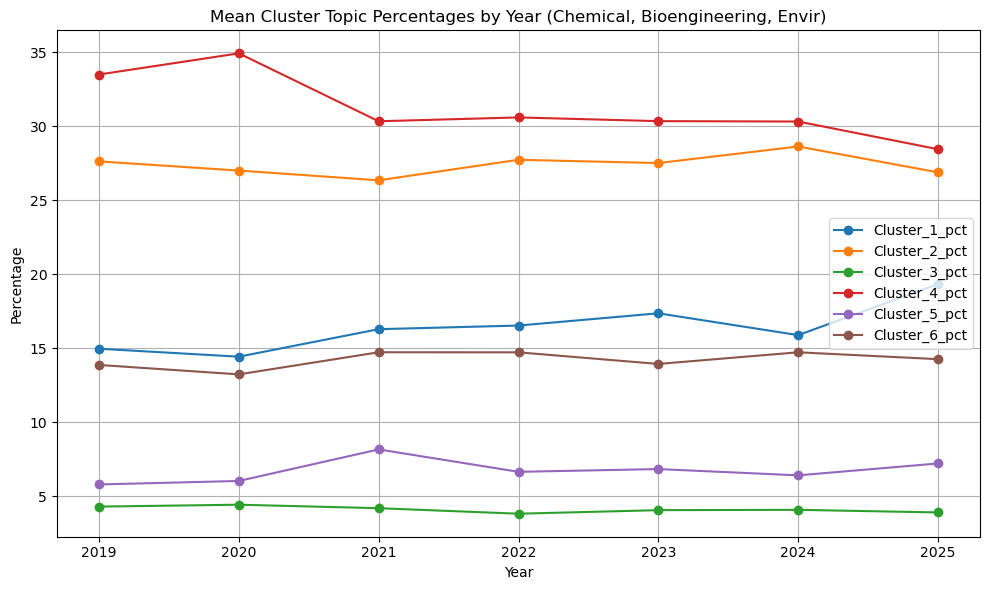

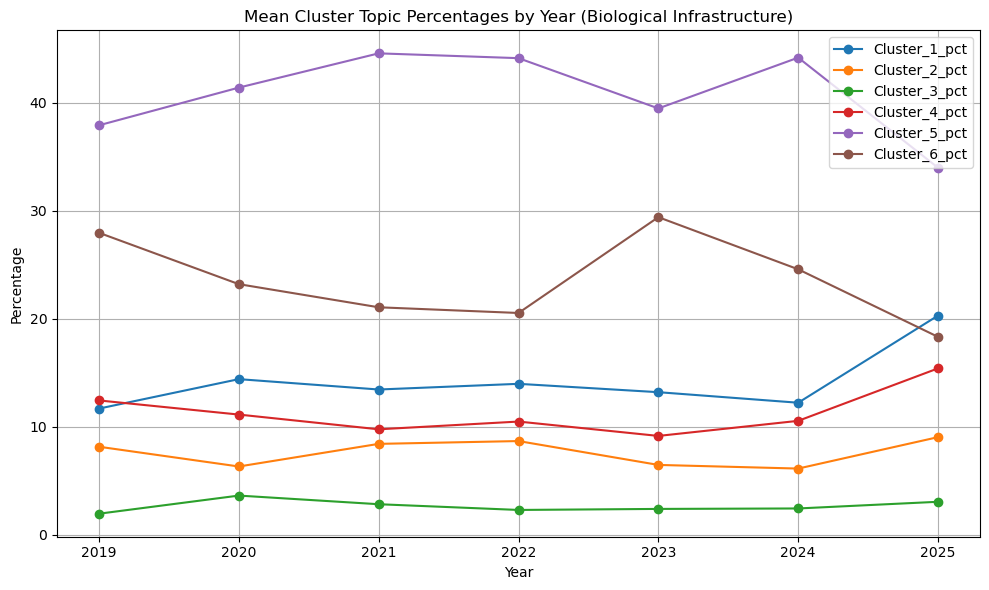

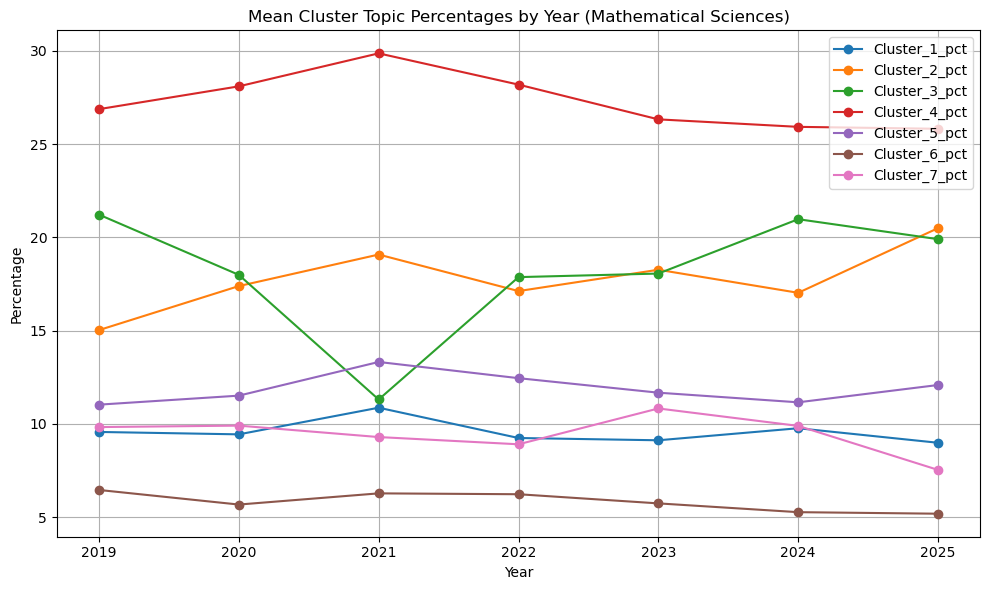

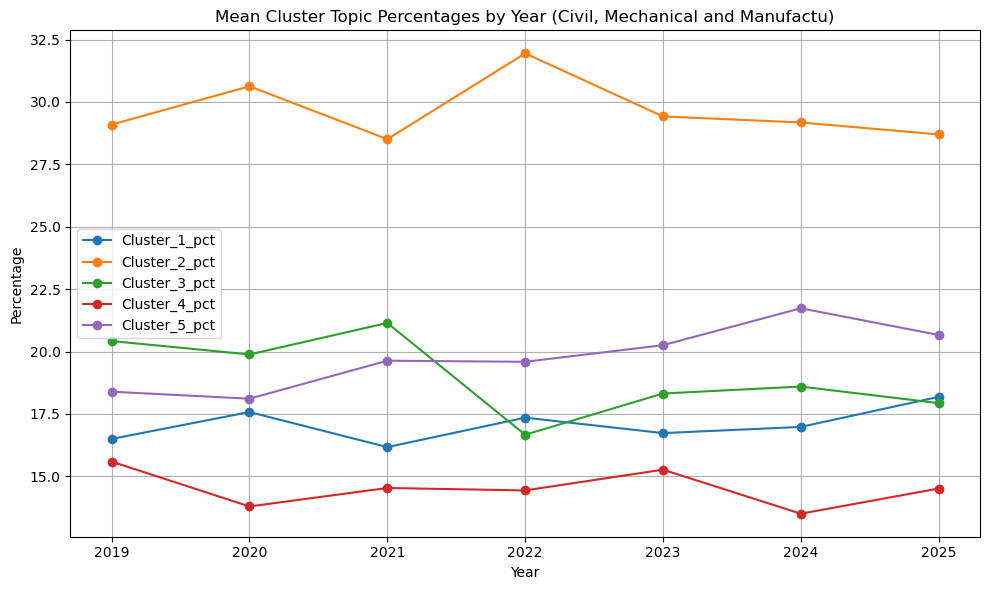

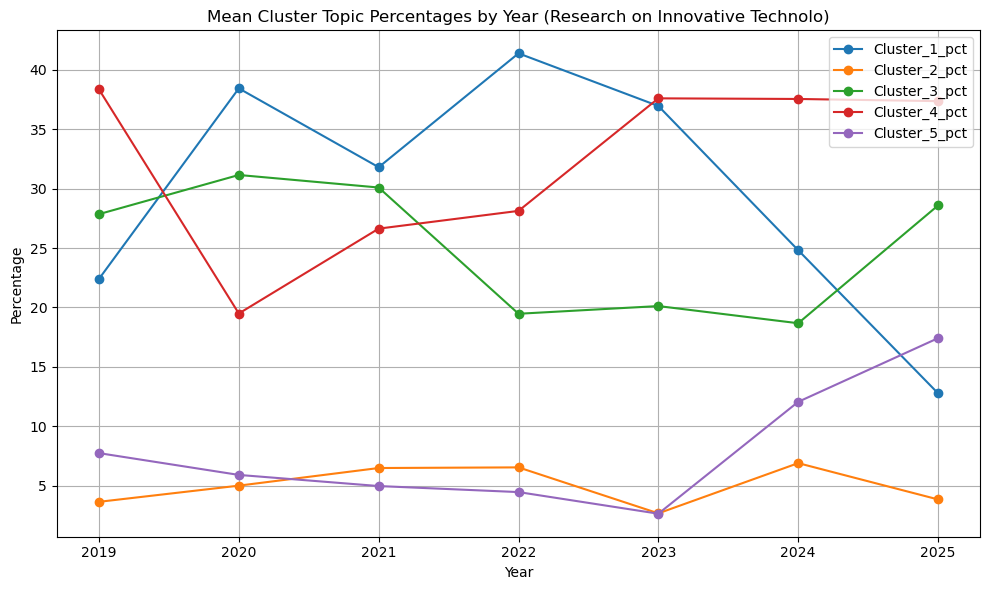

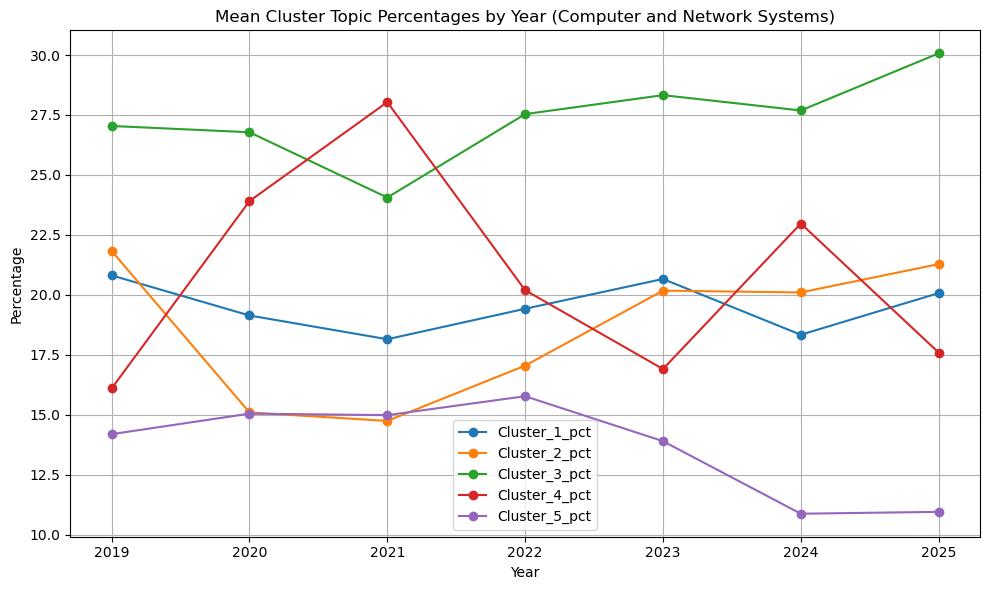

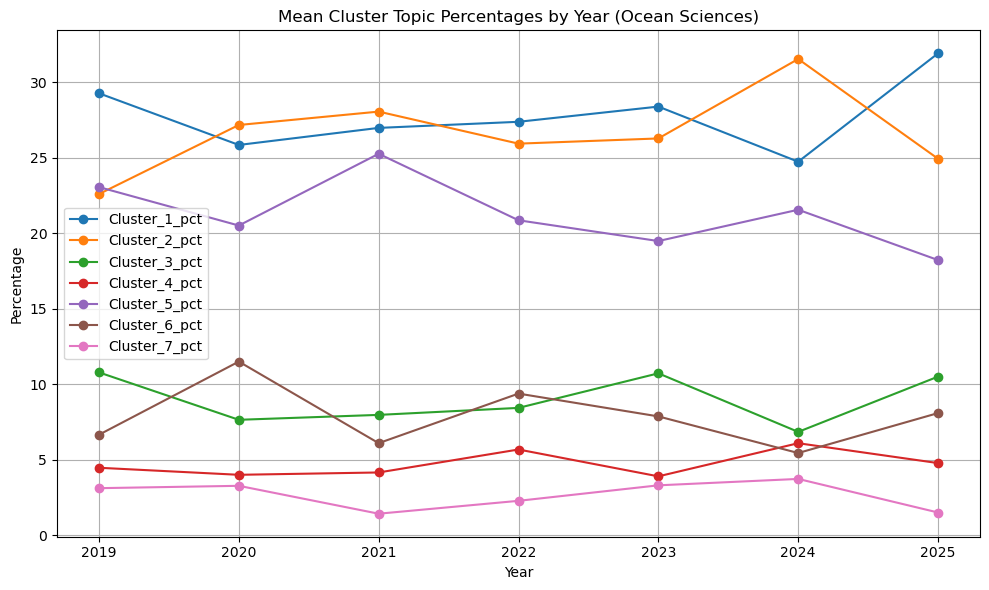

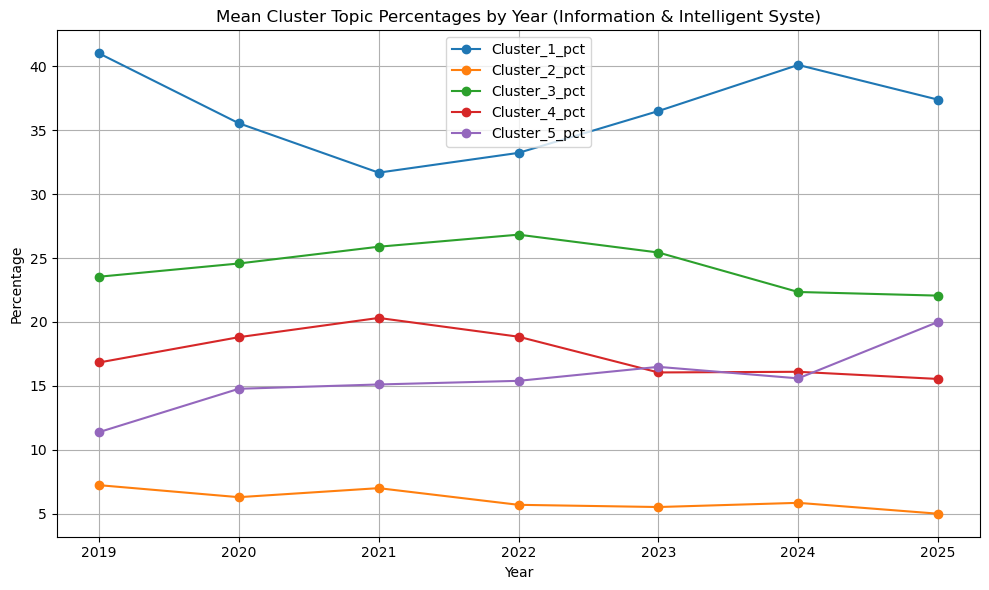

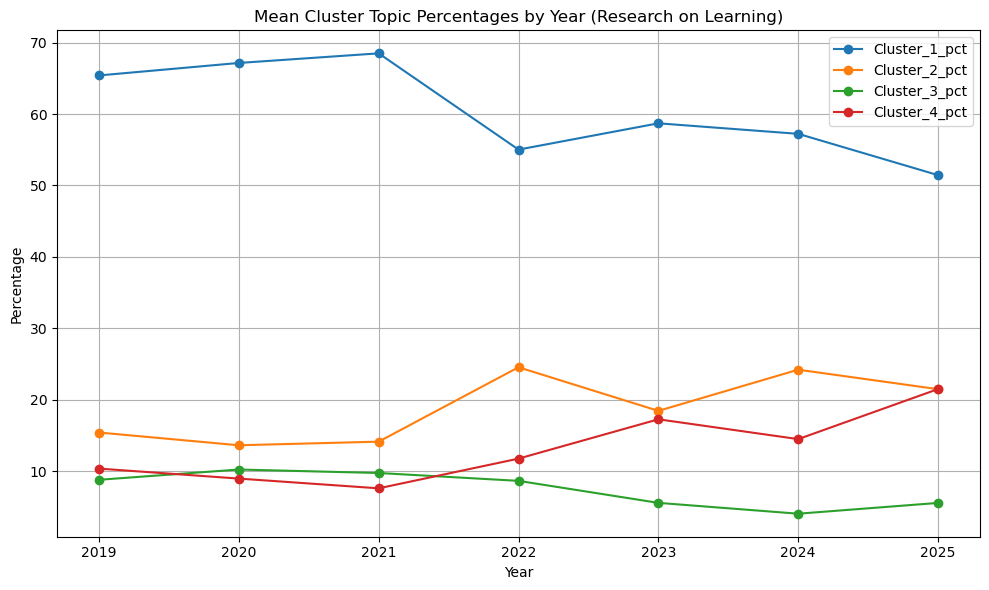

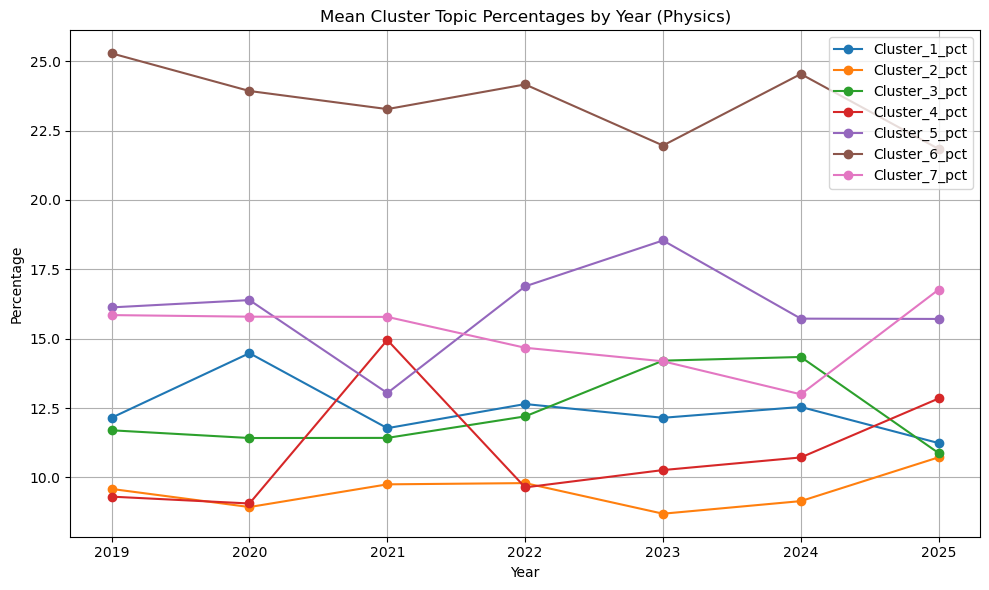

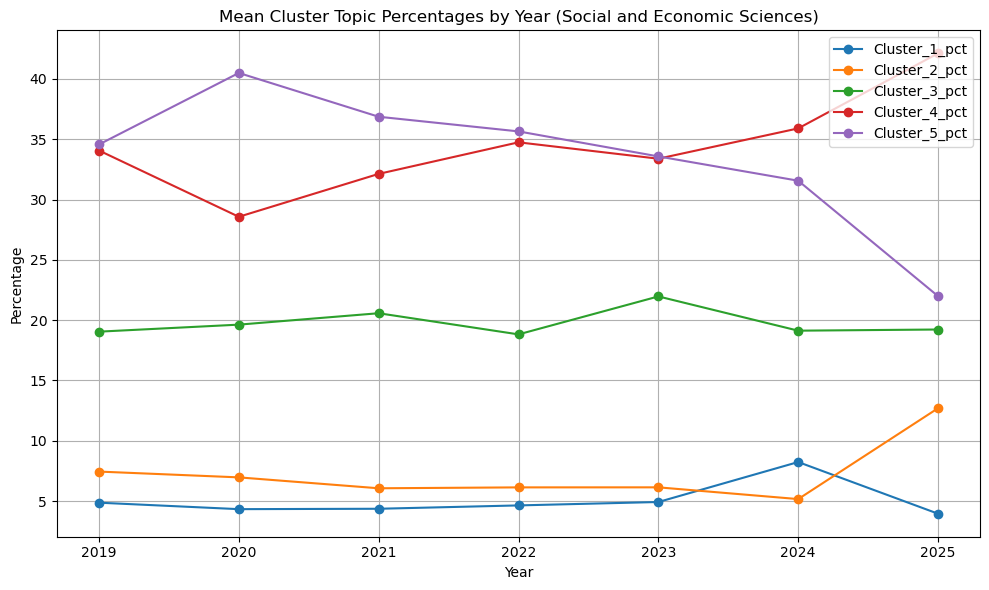

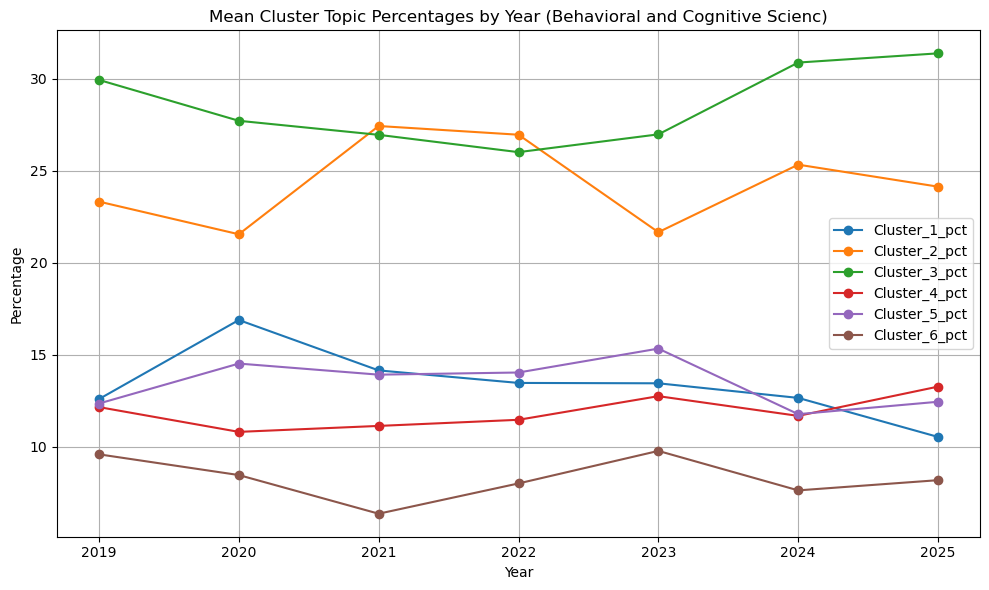

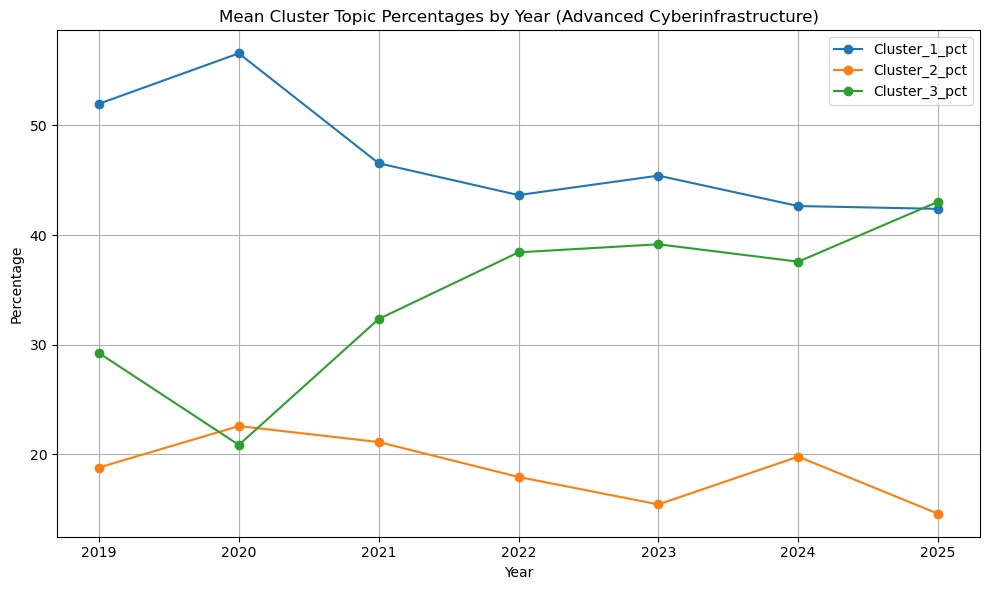

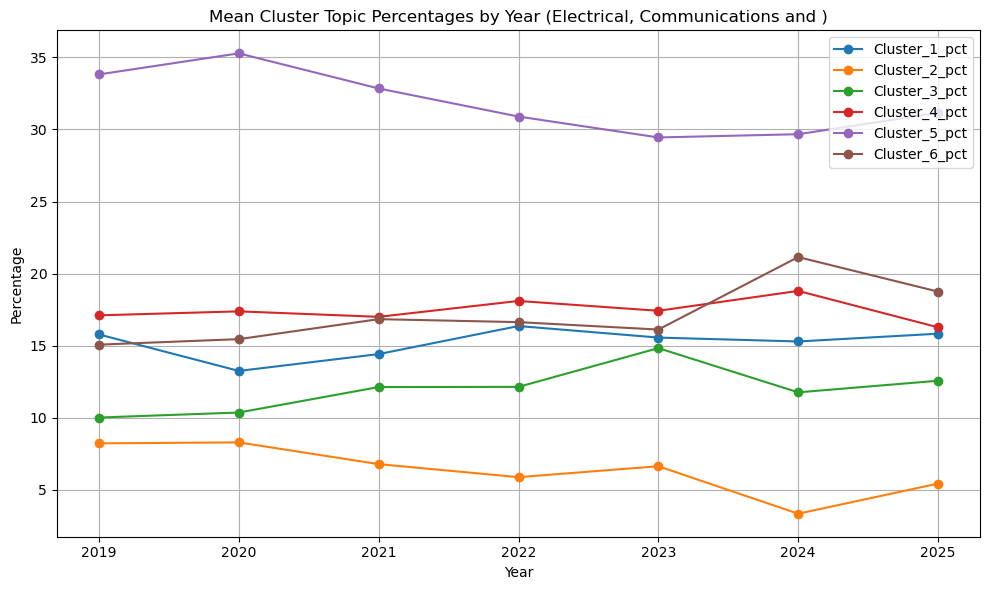

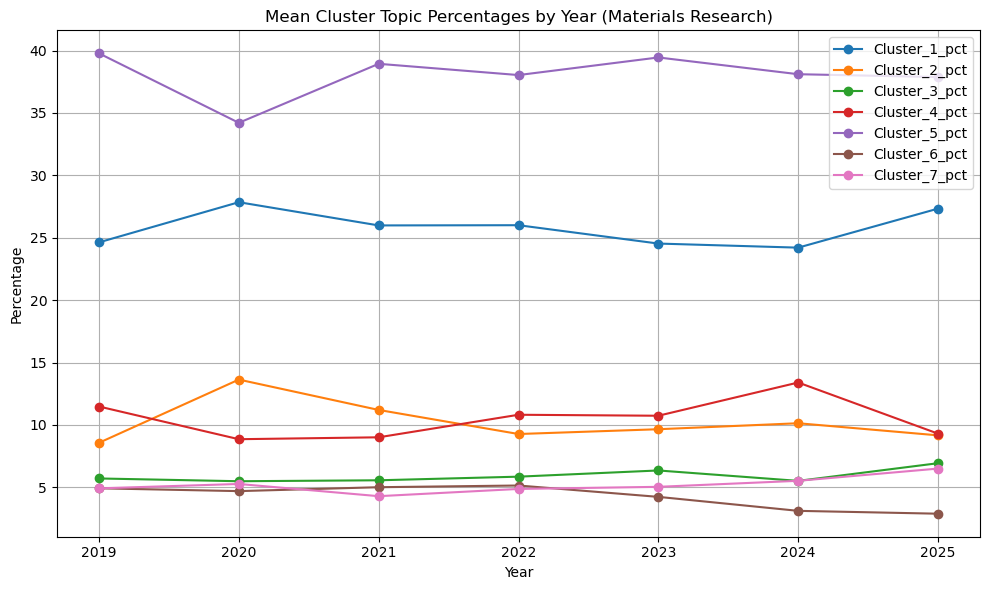

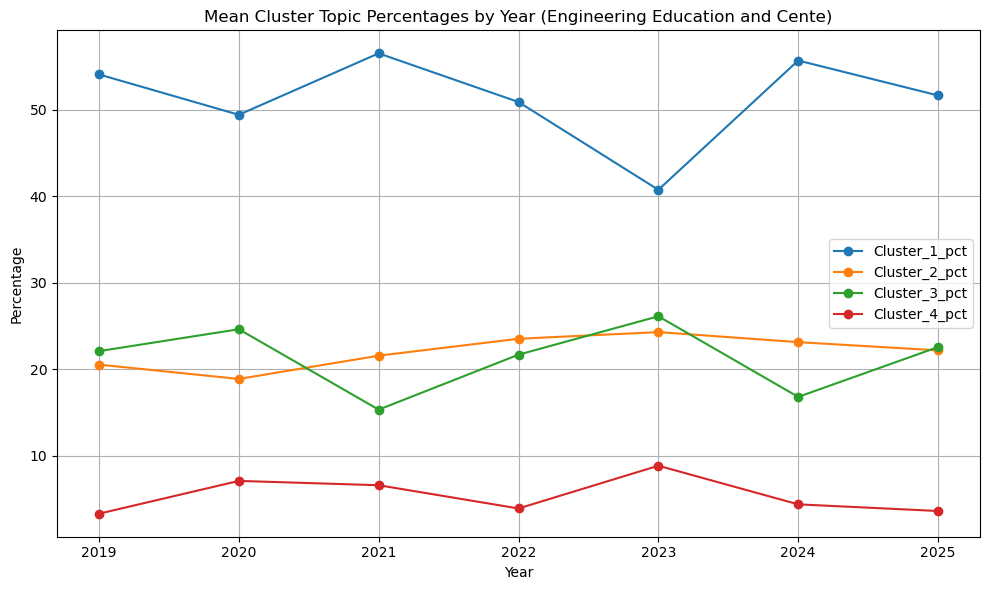

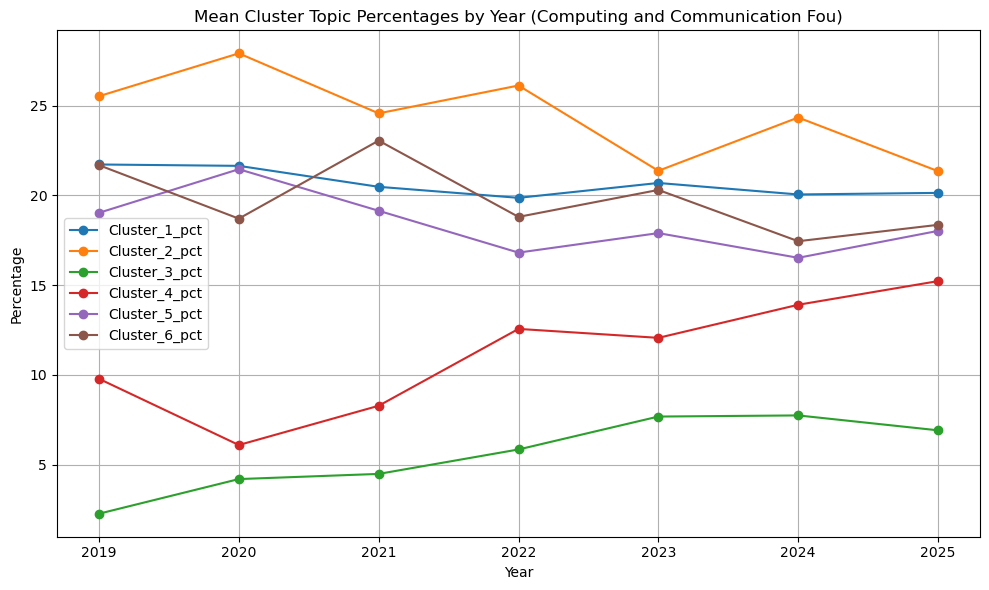

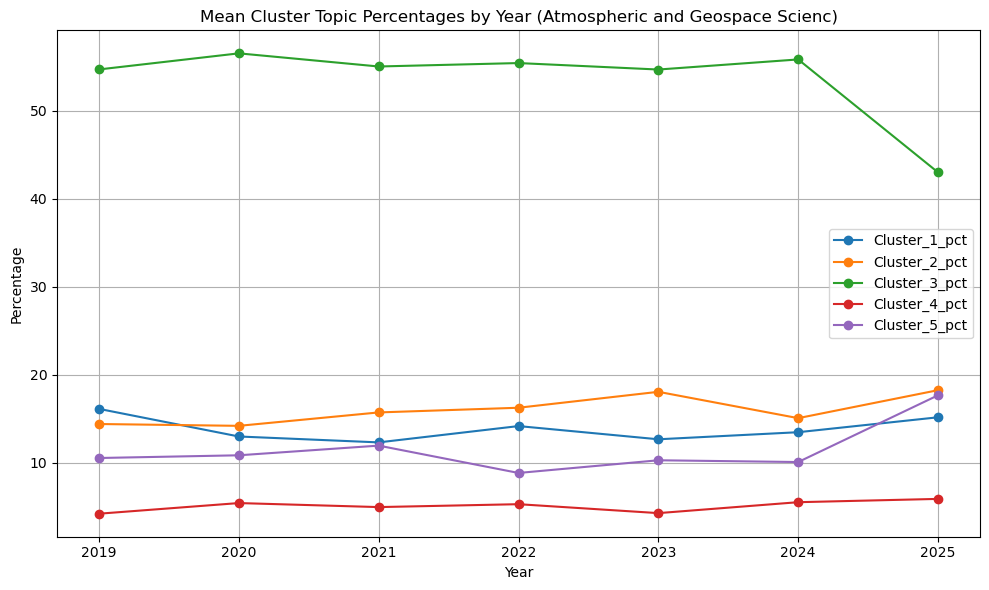

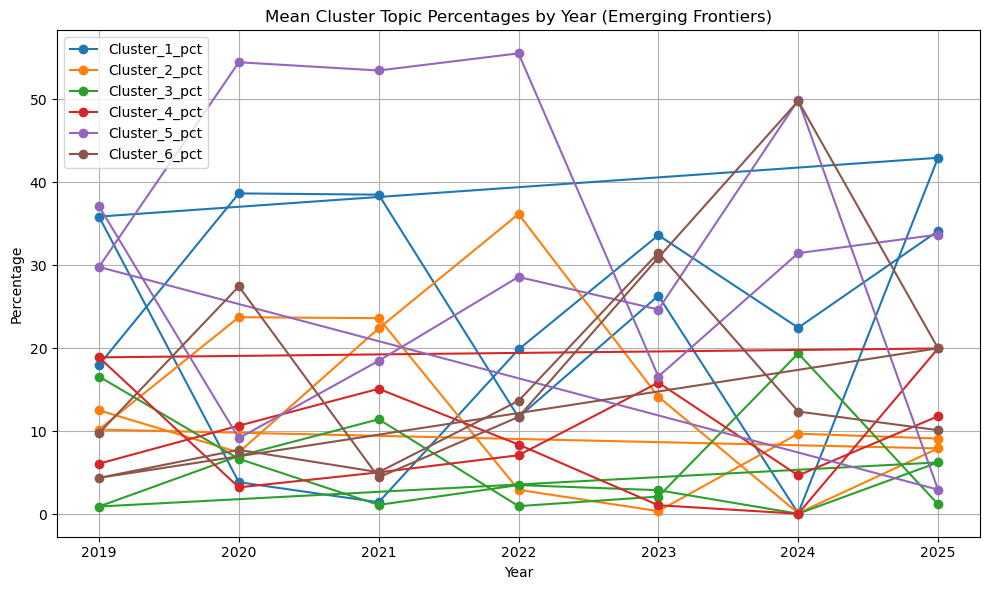

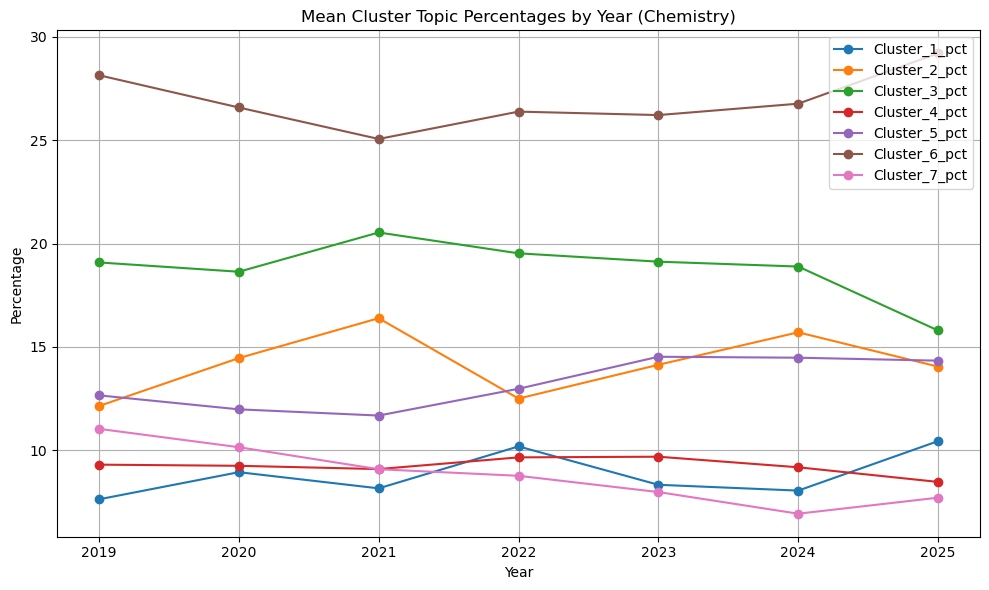

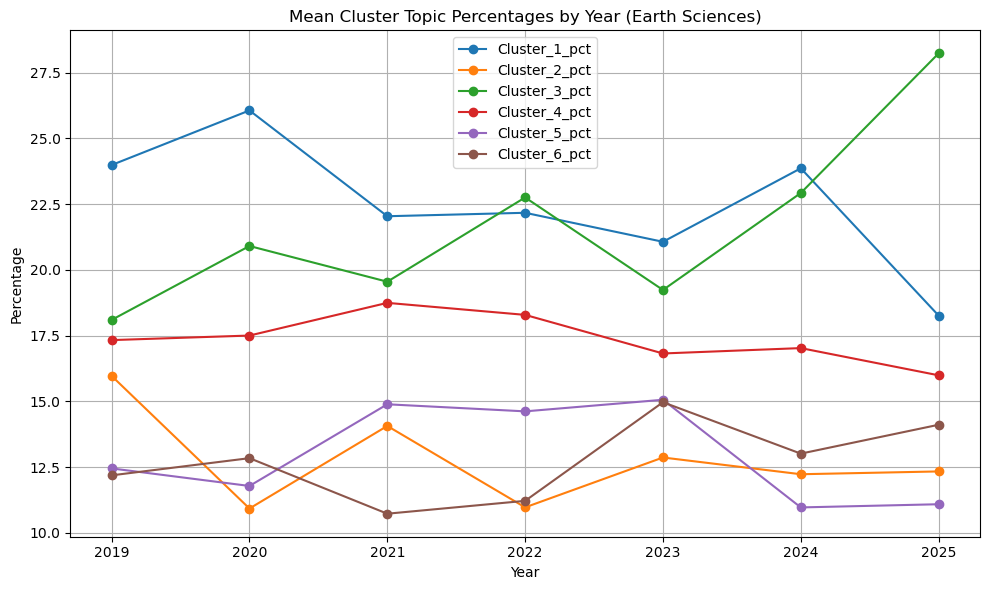

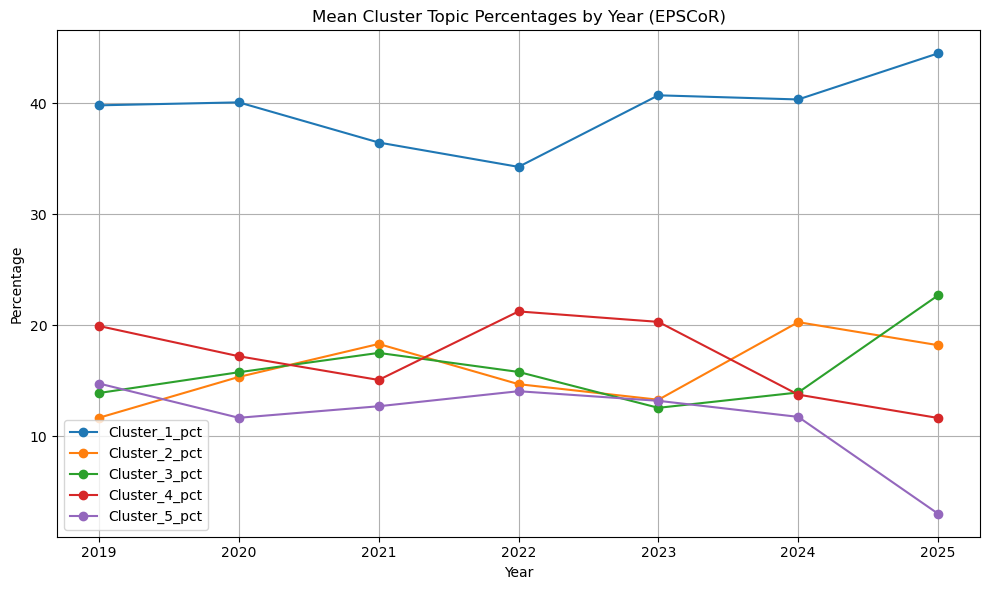

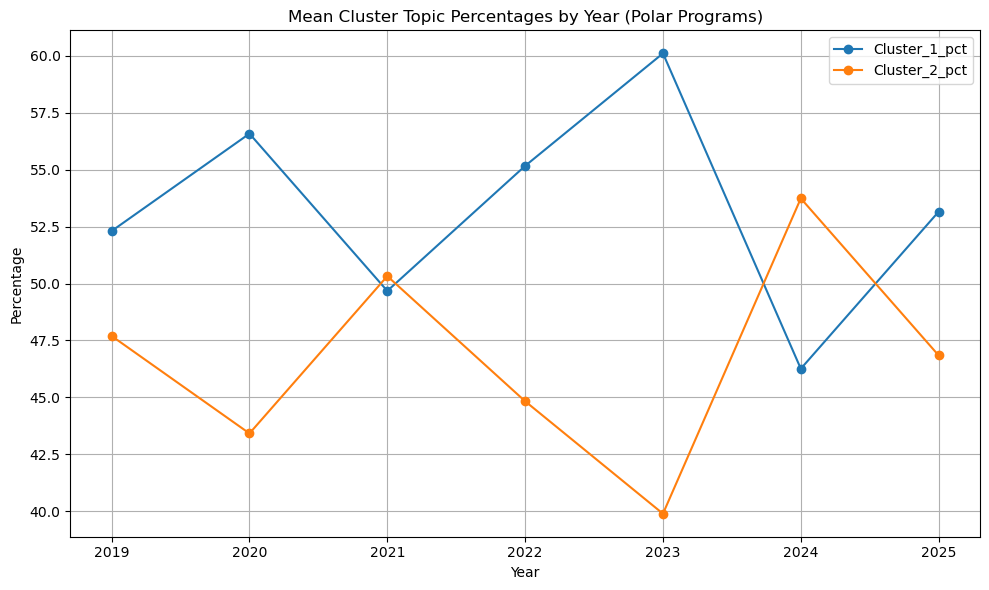

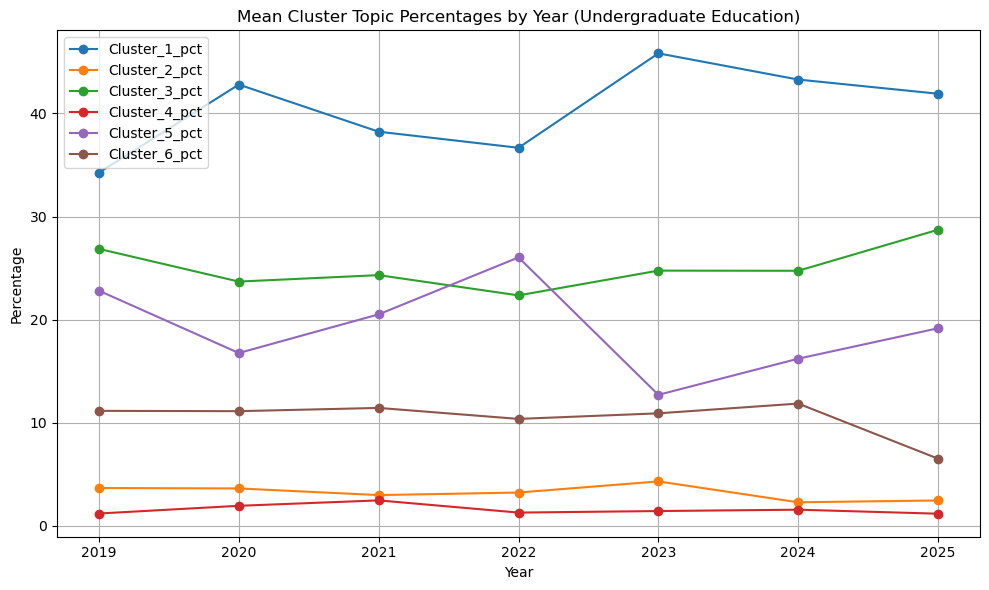

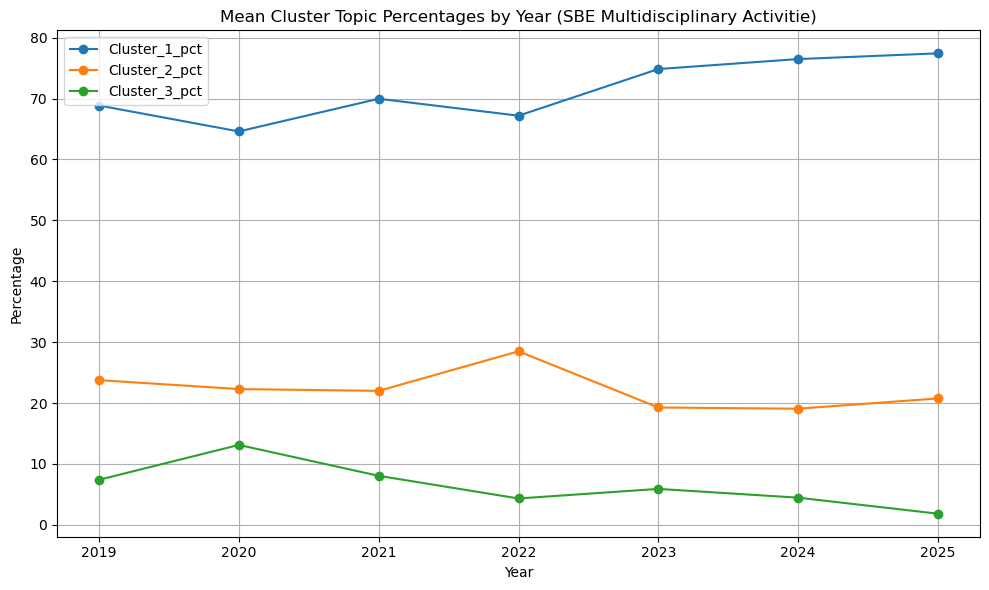

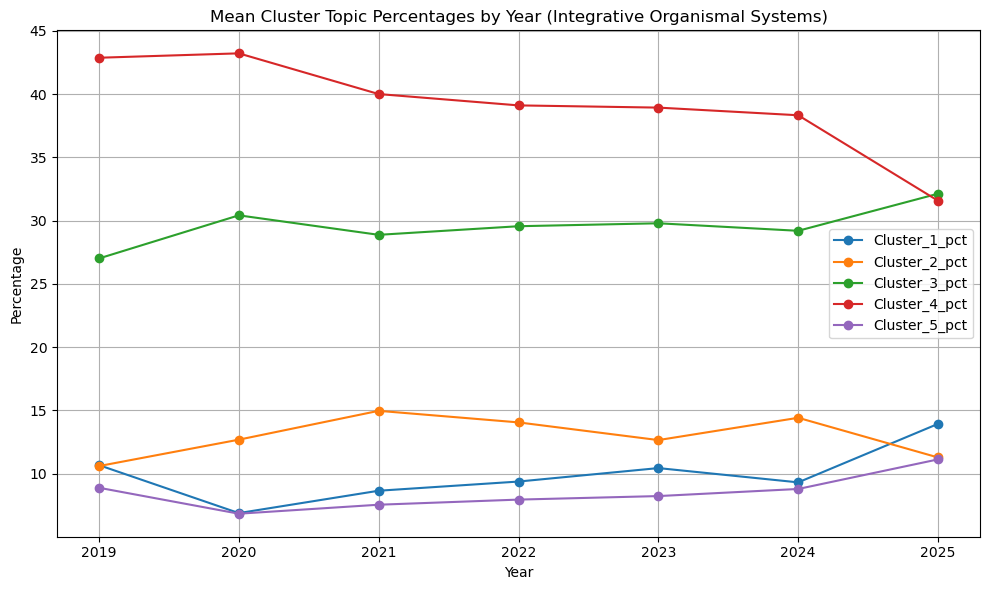

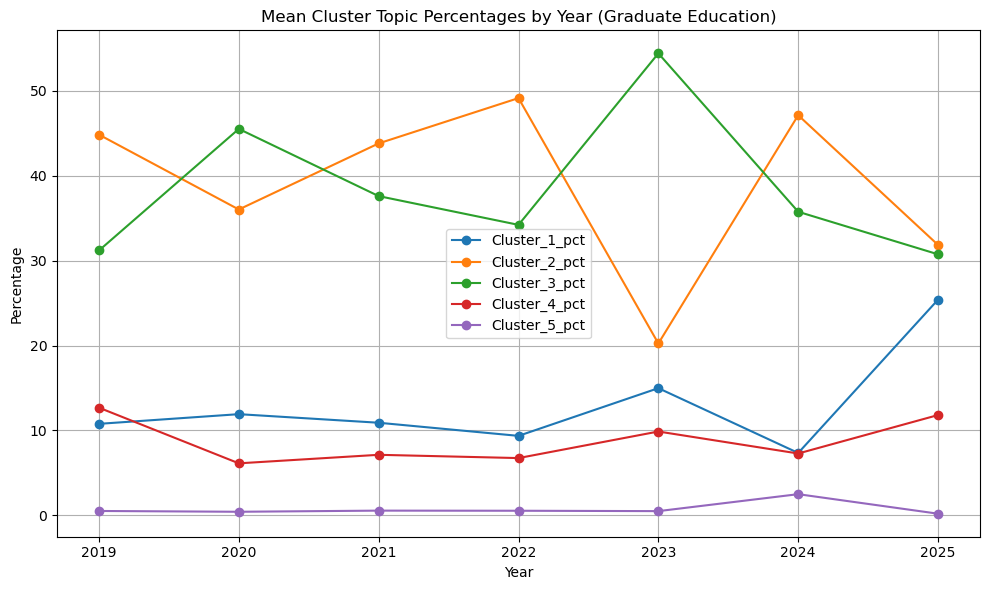

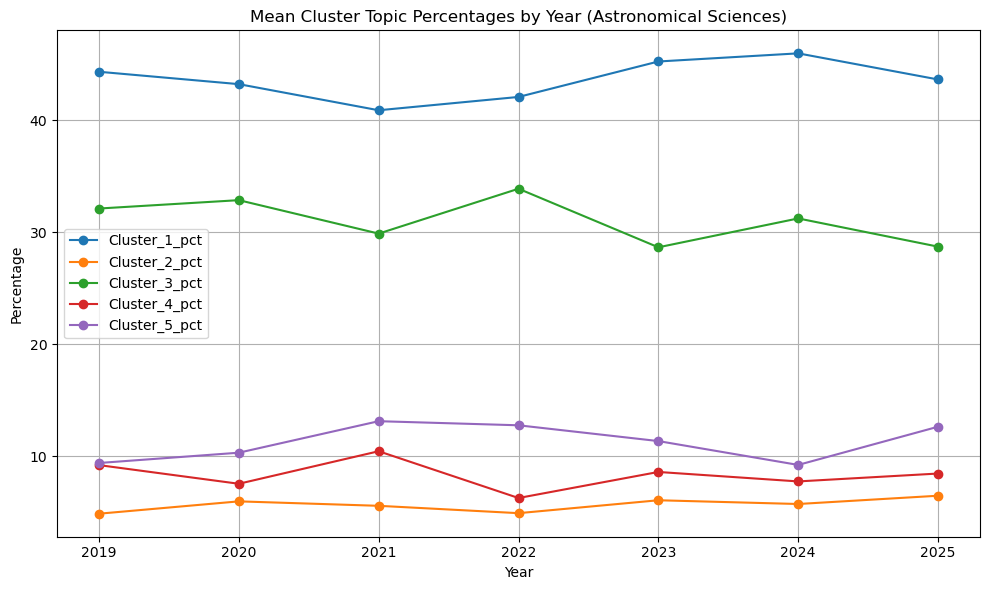

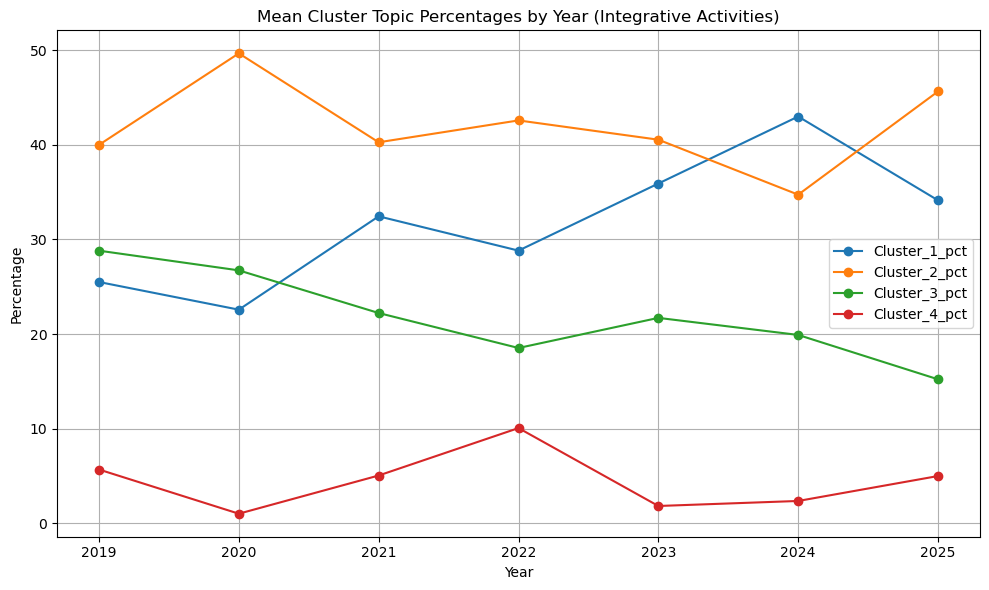

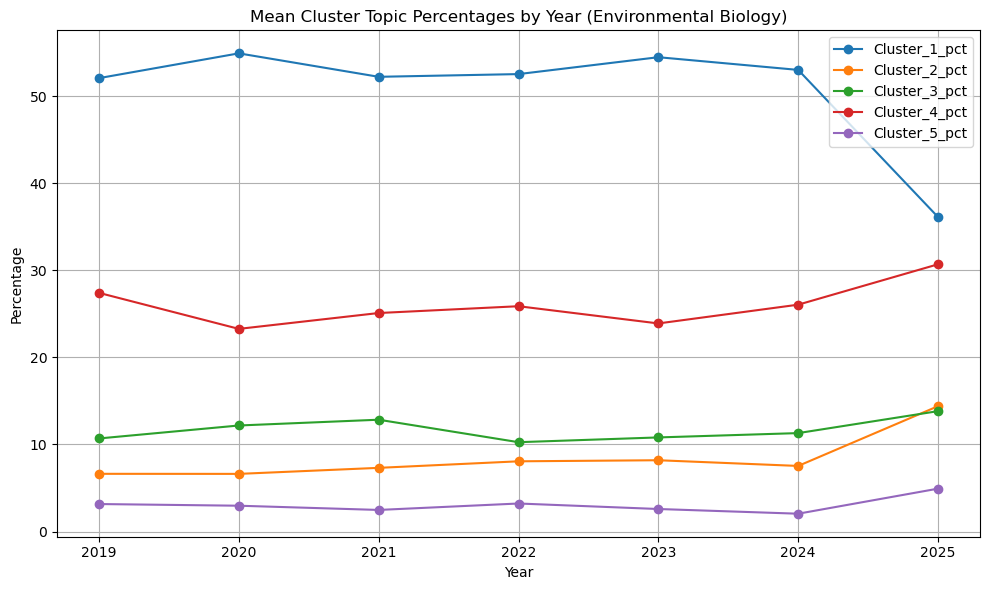

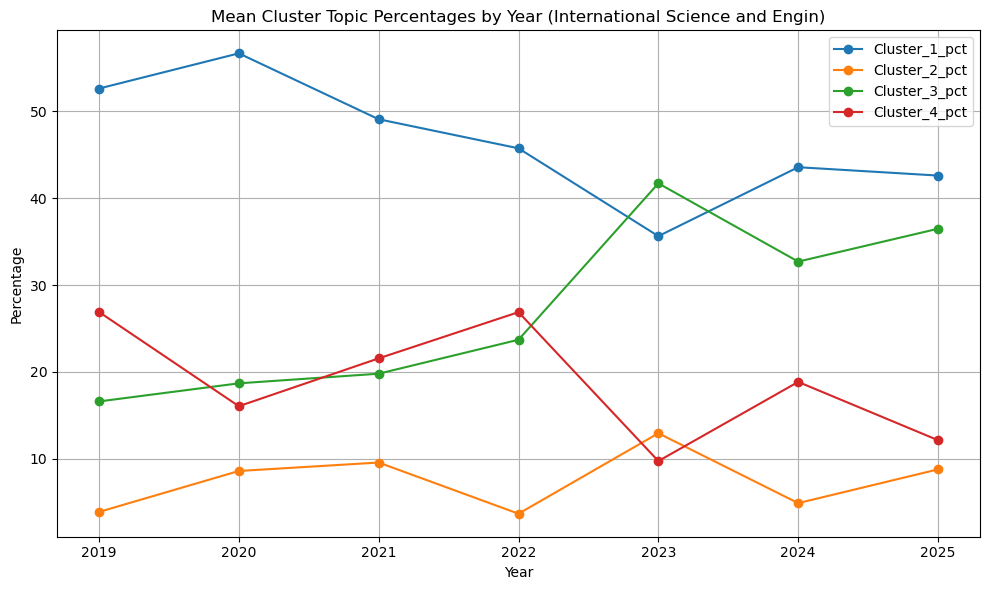

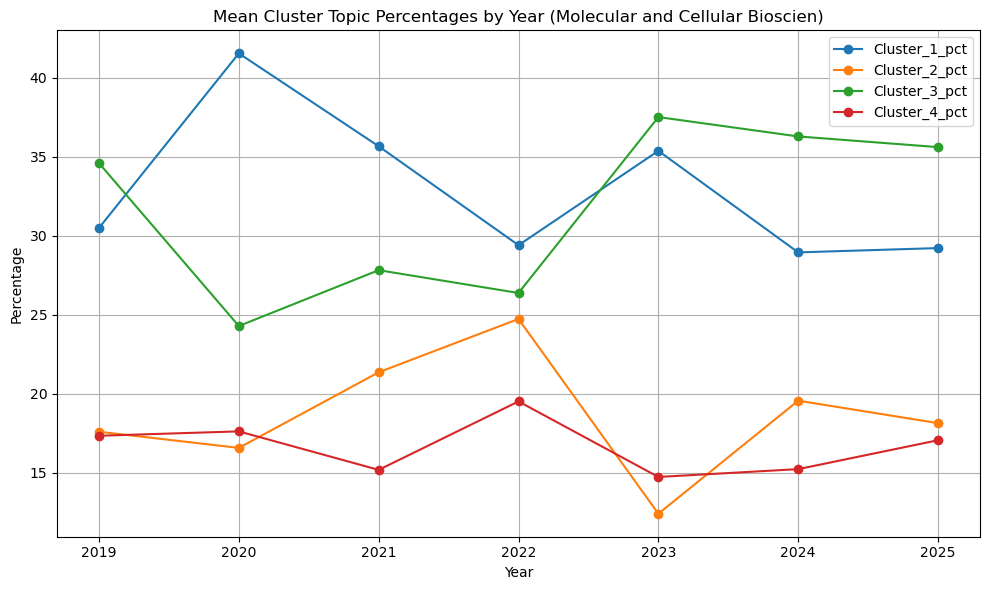

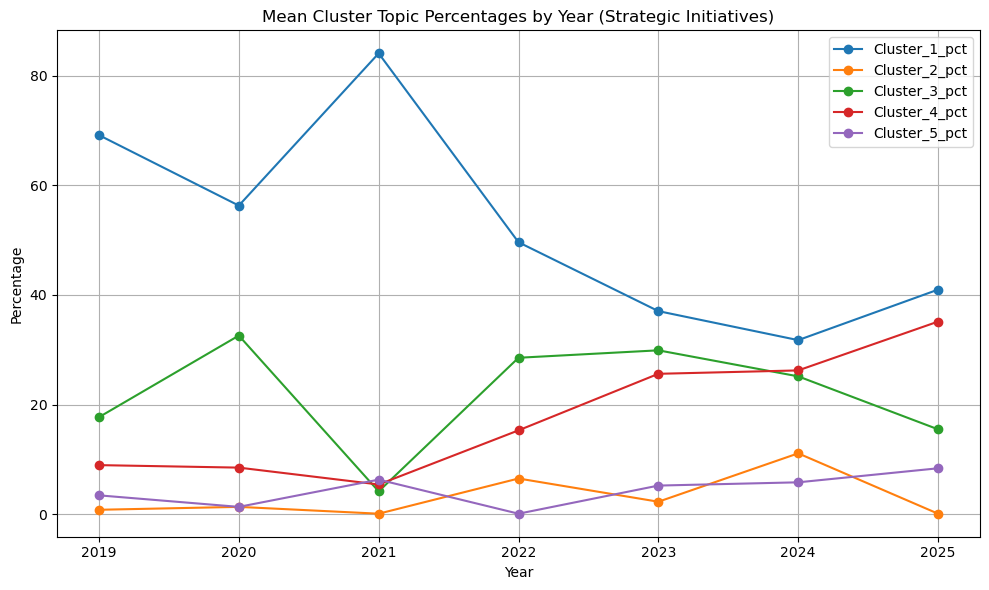

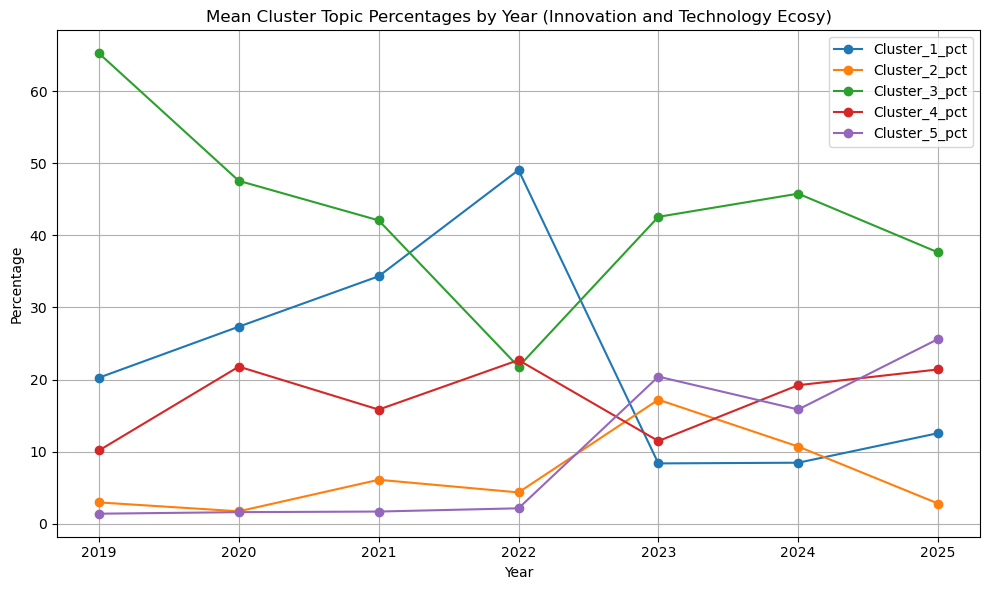

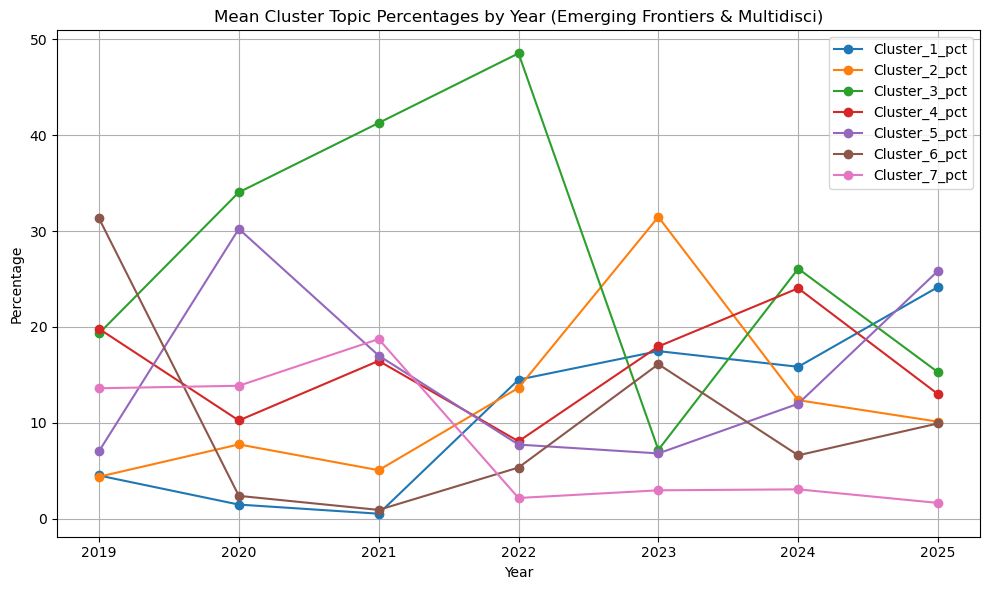

In [99]:
topic_cols = [col for col in orig_assignments.columns if col.startswith("Topic_")]

grouped = orig_assignments.groupby(["division", "year"])[topic_cols].mean().reset_index()

for topic in cluster_assignments:

    cluster_ids = set(cluster_assignments[topic].values())
    topic_df_vals = grouped[grouped["division"].str.contains(topic, na=False)].copy()

    for cid in cluster_ids:
        # which topics belong to this cluster?
        topic_ids_in_cluster = [tid for tid, c in cluster_assignments[topic].items() if c == cid]
        
        cols_in_cluster = [f"{tid}_pct".replace(" ","_") for tid in topic_ids_in_cluster]
        
        # sum across those topic columns row-wise
        topic_df_vals.loc[:,f"Cluster_{cid}_pct"] = topic_df_vals[cols_in_cluster].sum(axis=1)
    
    cluster_cols = [f"Cluster_{cid}_pct" for cid in cluster_ids]
    plot_yearly_cluster_dist(topic_df_vals, cluster_cols, topic)